# Role Archetypes Analysis

### Load Data and Clean Data

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# load clustered dataset
df = pd.read_csv("/content/jobs_with_clusters_v1.csv")

# basic cleaning
df = df[
    df["job_cluster"].notna() &
    df["skills_norm"].notna() &
    df["experience_level"].notna()
]

df["job_cluster"] = df["job_cluster"].astype(int)

/tmp/ipython-input-1230211150.py:5: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/jobs_with_clusters_v1.csv")


### Ensure Column Datatype (skill_norms)

In [15]:
import ast

def safe_list(x):
    if isinstance(x, list):
        return x
    try:
        return ast.literal_eval(x)
    except:
        return []

df["skills_norm"] = df["skills_norm"].apply(safe_list)

### Top Skills per Role Archetype

In [16]:
from collections import Counter

cluster_skills = {}

for cluster_id, group in df.groupby("job_cluster"):
    all_skills = [skill for skills in group["skills_norm"] for skill in skills]
    top_skills = Counter(all_skills).most_common(10)
    cluster_skills[cluster_id] = top_skills

# convert to dataframe
skill_rows = []
for cluster, skills in cluster_skills.items():
    for skill, count in skills:
        skill_rows.append({
            "job_cluster": cluster,
            "skill": skill,
            "frequency": count
        })

cluster_skill_df = pd.DataFrame(skill_rows)
cluster_skill_df.head()

,job_cluster,skill,frequency
0,0,excel,2121
1,0,aws,712
2,0,git,420
3,0,react,44
4,0,azure,40


### Salary Profile per cluster

In [19]:
salary_profile = (
    df.groupby("job_cluster")["salary_final"]
    .agg(["median", "mean", "count"])
    .reset_index()
    .sort_values("median", ascending=False)
)

salary_profile

,job_cluster,median,mean,count
7,7,105000.000,98883.456595,1025
0,0,92000.000,87526.058957,901
4,4,76000.000,73989.577112,187
3,3,67500.000,67677.105654,1905
2,2,65000.000,74863.024122,376
8,8,1500.000,44604.984565,3621
5,5,57.000,39669.983314,676
1,1,24.735,17929.344697,1288
6,6,16.500,1161.693235,371
9,9,NaN,NaN,0


### Experience Distribution per Archetype

In [20]:
exp_profile = (
    df.groupby(["job_cluster", "experience_level"])
    .size()
    .reset_index(name="count")
)

exp_profile.head()

,job_cluster,experience_level,count
0,0,Associate,507
1,0,Director,196
2,0,Entry level,1119
3,0,Executive,42
4,0,Internship,51


### Combine into One Archetype Summary Table

In [21]:
# Most common experience level per cluster
dominant_exp = (
    exp_profile
    .sort_values("count", ascending=False)
    .groupby("job_cluster")
    .first()
    .reset_index()
)

archetype_summary = salary_profile.merge(
    dominant_exp[["job_cluster", "experience_level"]],
    on="job_cluster",
    how="left"
)

archetype_summary.rename(columns={
    "median": "median_salary_usd",
    "mean": "avg_salary_usd",
    "count": "job_postings",
    "experience_level": "dominant_experience"
}, inplace=True)

archetype_summary


,job_cluster,median_salary_usd,avg_salary_usd,job_postings,dominant_experience
0,7,105000.000,98883.456595,1025,Mid-Senior level
1,0,92000.000,87526.058957,901,Mid-Senior level
2,4,76000.000,73989.577112,187,Mid-Senior level
3,3,67500.000,67677.105654,1905,Mid-Senior level
4,2,65000.000,74863.024122,376,Mid-Senior level
5,8,1500.000,44604.984565,3621,Mid-Senior level
6,5,57.000,39669.983314,676,Entry level
7,1,24.735,17929.344697,1288,Entry level
8,6,16.500,1161.693235,371,Entry level
9,9,NaN,NaN,0,Mid-Senior level


### Salary By Role Archetype

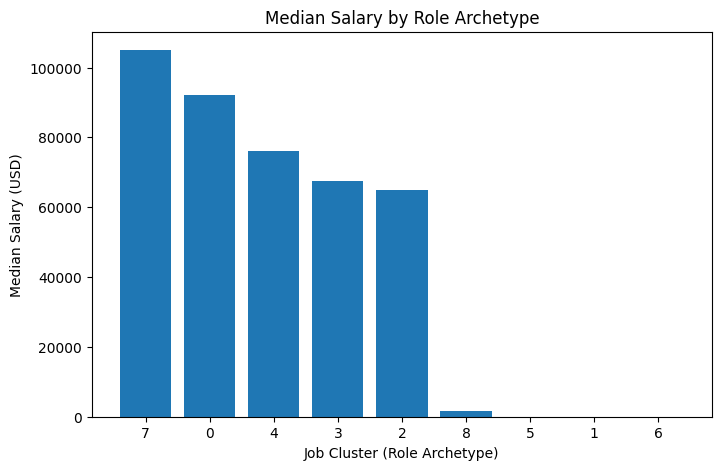

In [22]:
plt.figure(figsize=(8,5))
plt.bar(
    archetype_summary["job_cluster"].astype(str),
    archetype_summary["median_salary_usd"]
)
plt.xlabel("Job Cluster (Role Archetype)")
plt.ylabel("Median Salary (USD)")
plt.title("Median Salary by Role Archetype")
plt.show()

### Skill Signatures by Archetype

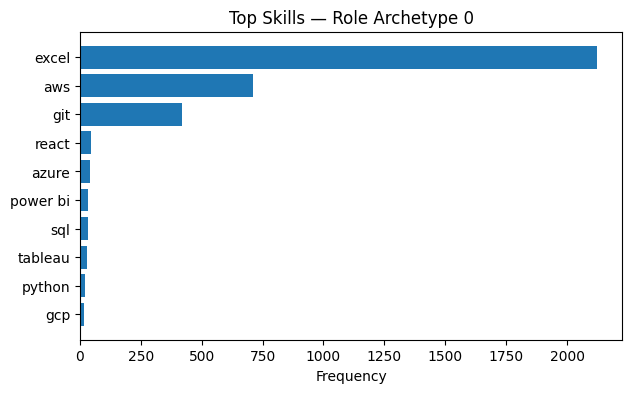

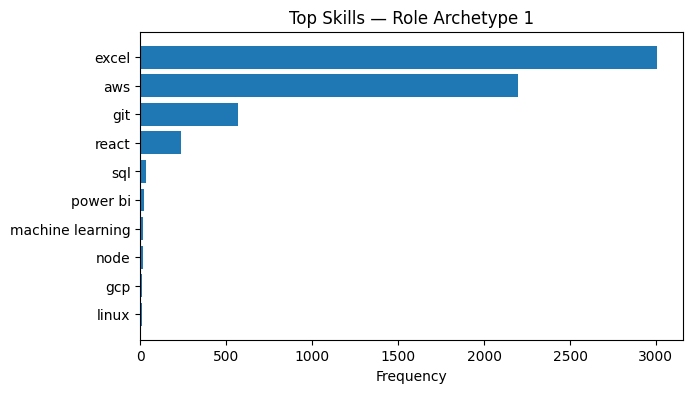

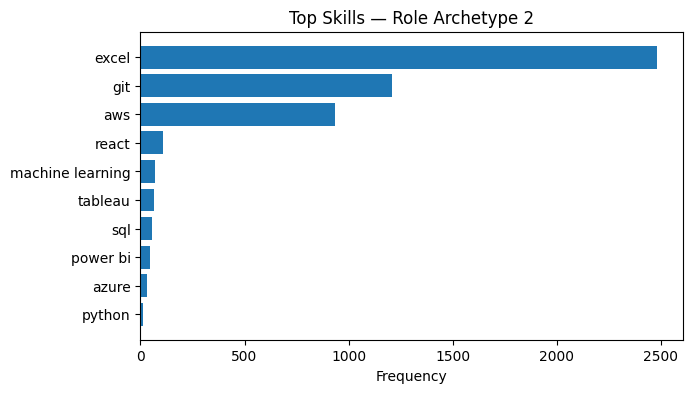

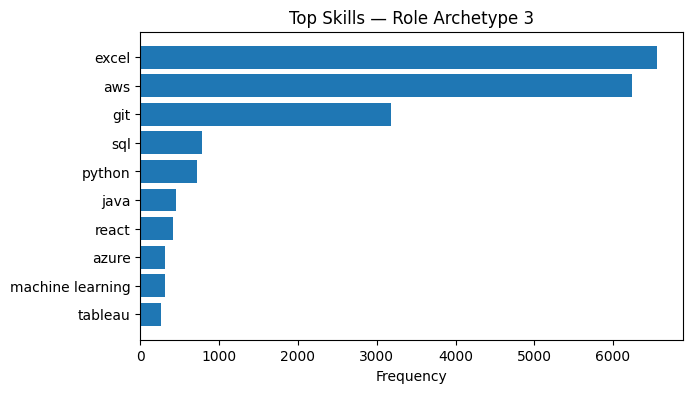

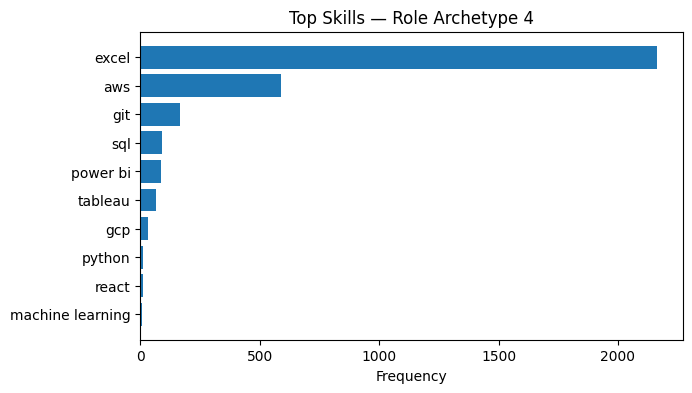

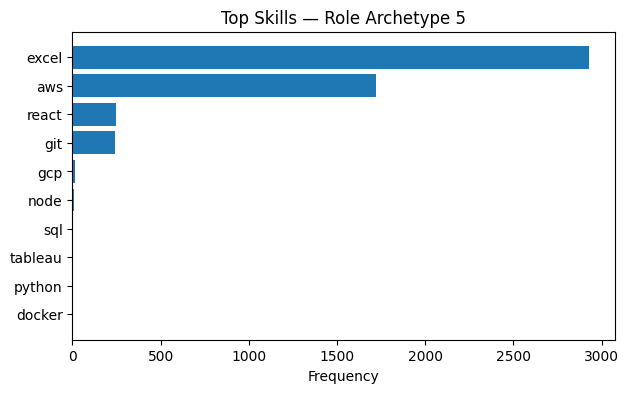

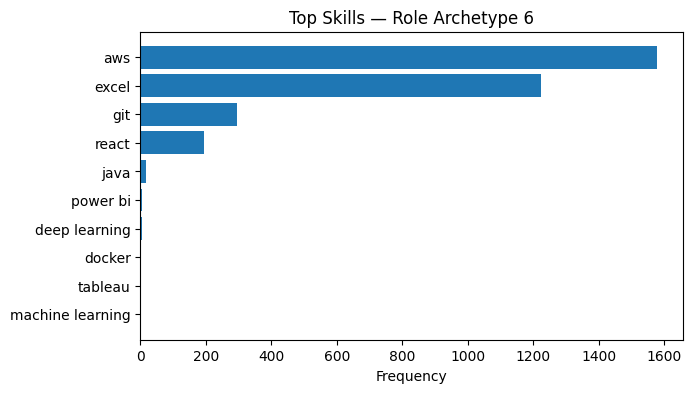

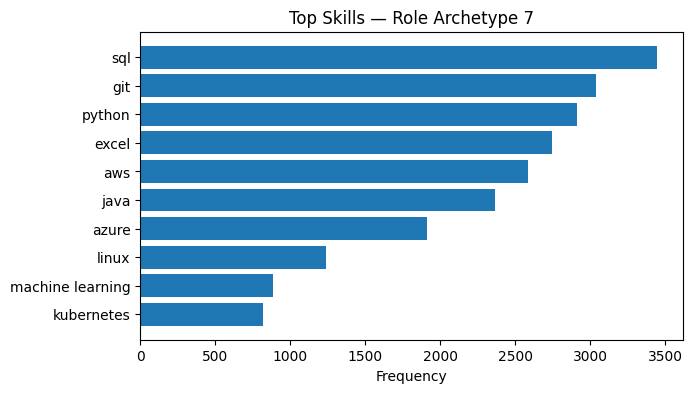

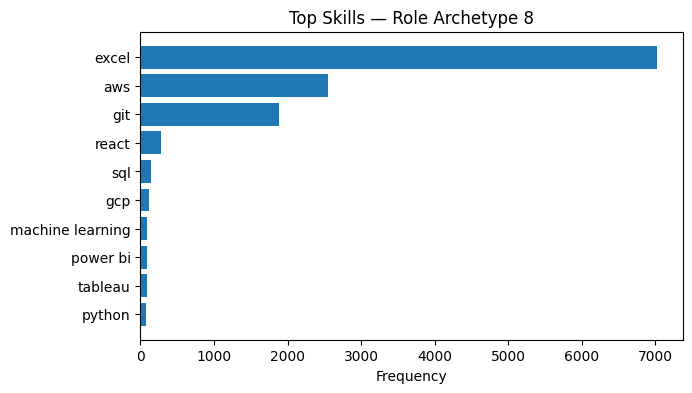

In [23]:
for cluster_id in cluster_skill_df["job_cluster"].unique():
    subset = cluster_skill_df[cluster_skill_df["job_cluster"] == cluster_id]

    plt.figure(figsize=(7,4))
    plt.barh(subset["skill"], subset["frequency"])
    plt.title(f"Top Skills — Role Archetype {cluster_id}")
    plt.xlabel("Frequency")
    plt.gca().invert_yaxis()
    plt.show()

### Export Summaries

In [24]:
archetype_summary.to_csv("role_archetype_summary.csv", index=False)
cluster_skill_df.to_csv("role_archetype_skills.csv", index=False)

## Interpretation

**Role Archetypes & Skill Profiles**

- Each role archetype shows a distinct skill signature, confirming clustering worked as intended.

- Excel + AWS-heavy clusters dominate multiple archetypes → strong indicator of operations, business, and analytics-heavy roles.

- Archetype 7 clearly represents Software / Data / Engineering roles, with high presence of SQL, Python, Git, AWS, Java, and Kubernetes.

- Lower-index archetypes (0, 1, 4, 8) skew toward administrative, retail, and operations roles, dominated by Excel, basic cloud tools, and limited programming.

**Salary Distribution by Archetype**

**Highest median salary:**

- Archetype 7 → Software, Data, and Engineering roles

**Mid-tier salaries:**

- Archetypes 0, 4, 3, 2 → finance, management, mixed technical/business roles

**Lowest salaries:**

- Archetypes 1, 5, 6, 8 → support, retail, healthcare support, and operational roles

- Salary differences align strongly with depth of technical skill stack, not just tool count.

**Key Insight**

- Role archetypes represent career lanes, not just job titles — and technical depth + cloud + data skills consistently map to higher pay bands.